**Installing Requirements**

In [ ]:
pip install Pillow jina torch==1.9.0 torchvision==0.10.0 transformers==4.9.1 matplotlib

In [ ]:
! rm -rf workspace images query data*.zip* SimpleIndexer

**Downloading and unzipping data**

In [ ]:
! wget https://open-images.s3.eu-central-1.amazonaws.com/data.zip
! unzip data.zip

--2021-11-11 06:58:05--  https://open-images.s3.eu-central-1.amazonaws.com/data.zip
Resolving open-images.s3.eu-central-1.amazonaws.com (open-images.s3.eu-central-1.amazonaws.com)... 52.219.75.236
Connecting to open-images.s3.eu-central-1.amazonaws.com (open-images.s3.eu-central-1.amazonaws.com)|52.219.75.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5018728 (4.8M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   4.79M  4.36MB/s    in 1.1s    

2021-11-11 06:58:07 (4.36 MB/s) - ‘data.zip’ saved [5018728/5018728]

Archive:  data.zip
   creating: images/
  inflating: images/cat1.jpg         
  inflating: images/cat2.jpg         
  inflating: images/cat-dog2.jpg     
  inflating: images/dog.jpg          
  inflating: images/person-bicycle-dog.jpg  
  inflating: images/cat-bird.jpg     
  inflating: images/bird-dog.jpg     
  inflating: images/person-bicycle1.jpg  
  inflating: images/bicycle.jpg      
  inflating: im

## **Imports**
We import all the  necessary libraries and tools.

In [ ]:
from typing import Dict, Optional, Sequence
from transformers import CLIPModel, CLIPTokenizer ,  CLIPFeatureExtractor
from jina import Document, DocumentArray , Flow, Executor, requests
from typing import Optional, Tuple
import torch
from copy import deepcopy
import inspect
from jina.types.request import Request
import glob 
import os 
import matplotlib.pyplot as plt
from jina import DocumentArray, Executor, requests
from jina.logging.logger import JinaLogger
from jina.types.arrays.memmap import DocumentArrayMemmap

## **Executors**
In this section, we will start developing the necessary executors, for both query and index flows.

### **CLIPTextEncoder**
This encoder encodes a text into embeddings using the CLIP model. 
We want an executor that loads the CLIP model and encodes it during the query flow. 

Our executor should:
* support both **GPU** and **CPU**: That's why we will provision the `device` parameter and use it when encoding.
* be able to process documents in batches in order to use our resources effectively: To do so, we will use the 
parameter `batch_size`

In [ ]:
class CLIPTextEncoder(Executor):
    """Encode text into embeddings using the CLIP model."""

    def __init__(
        self,
        pretrained_model_name_or_path: str = 'openai/clip-vit-base-patch32',
        base_tokenizer_model: Optional[str] = None,
        max_length: int = 77,
        device: str = 'cpu',
        traversal_paths: Sequence[str] = ['r'],
        batch_size: int = 32,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.traversal_paths = traversal_paths
        self.batch_size = batch_size
        self.pretrained_model_name_or_path = pretrained_model_name_or_path
        self.base_tokenizer_model = (
            base_tokenizer_model or pretrained_model_name_or_path
        )
        self.max_length = max_length

        self.device = device
        self.tokenizer = CLIPTokenizer.from_pretrained(self.base_tokenizer_model)
        self.model = CLIPModel.from_pretrained(self.pretrained_model_name_or_path)
        self.model.eval().to(device)

    @requests
    def encode(self, docs: Optional[DocumentArray], parameters: Dict, **kwargs):
        if docs is None:
            return

        for docs_batch in docs.traverse_flat(parameters.get('traversal_paths', self.traversal_paths)).batch(
            batch_size=parameters.get('batch_size', self.batch_size)
        ):
            text_batch = docs_batch.get_attributes('text')

            with torch.inference_mode():
                input_tokens = self._generate_input_tokens(text_batch)
                embeddings = self.model.get_text_features(**input_tokens).cpu().numpy()
                for doc, embedding in zip(docs_batch, embeddings):
                    doc.embedding = embedding

    def _generate_input_tokens(self, texts: Sequence[str]):

        input_tokens = self.tokenizer(
            texts,
            max_length=self.max_length,
            padding='longest',
            truncation=True,
            return_tensors='pt',
        )
        input_tokens = {k: v.to(self.device) for k, v in input_tokens.items()}
        return input_tokens

### **CLIPImageEncoder**
This encoder encodes an image into embeddings using the CLIP model. 
We want an executor that loads the CLIP model and encodes it during the index flow. 

Our executor should:
* support both **GPU** and **CPU**: That's why we will provision the `device` parameter and use it when encoding.
* be able to process documents in batches in order to use our resources effectively: To do so, we will use the 
parameter `batch_size`

In [ ]:
from typing import Optional, Tuple

import torch
from jina import DocumentArray, Executor, requests
from jina.logging.logger import JinaLogger
from transformers import CLIPFeatureExtractor, CLIPModel


class CLIPImageEncoder(Executor):
    """Encode image into embeddings using the CLIP model."""

    def __init__(
        self,
        pretrained_model_name_or_path: str = "openai/clip-vit-base-patch32",
        device: str = "cpu",
        batch_size: int = 32,
        traversal_paths: Tuple = ("r",),
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.traversal_paths = traversal_paths
        self.pretrained_model_name_or_path = pretrained_model_name_or_path

        self.device = device
        self.preprocessor = CLIPFeatureExtractor.from_pretrained(
            pretrained_model_name_or_path
        )
        self.model = CLIPModel.from_pretrained(self.pretrained_model_name_or_path)
        self.model.to(self.device).eval()

    @requests
    def encode(self, docs: Optional[DocumentArray], parameters: dict, **kwargs):
        if docs is None:
            return

        traversal_paths = parameters.get("traversal_paths", self.traversal_paths)
        batch_size = parameters.get("batch_size", self.batch_size)
        document_batches_generator =  docs.traverse_flat(parameters.get('traversal_paths', self.traversal_paths)).batch(
            batch_size=batch_size
        )

        with torch.inference_mode():
            for batch_docs in document_batches_generator:
                blob_batch = [d.blob for d in batch_docs]
                tensor = self._generate_input_features(blob_batch)


                embeddings = self.model.get_image_features(**tensor)
                embeddings = embeddings.cpu().numpy()

                for doc, embed in zip(batch_docs, embeddings):
                    doc.embedding = embed

    def _generate_input_features(self, images):
        input_tokens = self.preprocessor(
            images=images,
            return_tensors="pt",
        )
        input_tokens = {
            k: v.to(torch.device(self.device)) for k, v in input_tokens.items()
        }
        return input_tokens

**SimpleIndexer**
To implement SimpleIndexer, we can leverage jina's `DocumentArrayMemmap`. You can read about this data type [here](https://docs.jina.ai/fundamentals/document/documentarraymemmap-api/).

Our indexer will create an instance of `DocumentArrayMemmap` when it's initialized. We want to store indexed documents inside the workspace folder that's why we pass the `workspace` attribute of the executor to `DocumentArrayMemmap`.

To index, we implement the method `index` which is bound to the index flow. It's as simple as extending the received docs to `DocumentArrayMemmap` instance.

On the other hand, for search, we implement the method `search`. We bind it to the query flow using the decorator `@requests(on='/search')`.
In jina, searching for query documents can be done by adding the results to the `matches` attribute of each query document. Since docs is a `DocumentArray` we can use method `match` to match query against the indexed documents.
Read more about `match` [here](https://docs.jina.ai/fundamentals/document/documentarray-api/#matching-documentarray-to-another).
There's another detail here. We already indexed documents before search, but we need to match query documents against chunks of the indexed images. Luckily, `DocumentArray.match` allows us to specify the traversal paths of right-hand-side parameter with parameter `traversal_rdarray`. Since we want to match the left side docs (query) against the chunks of the right side docs (indexed docs), we can specify that `traversal_rdarray=['c']`.

In [ ]:
class SimpleIndexer(Executor):
    """
    A simple indexer that stores all the Document data together,
    in a DocumentArrayMemmap object
    To be used as a unified indexer, combining both indexing and searching
    """

    def __init__(
        self,
        match_args: Optional[Dict] = None,
        **kwargs,
    ):
        """
        Initializer function for the simple indexer
        :param match_args: the arguments to `DocumentArray`'s match function
        """
        super().__init__(**kwargs)

        self._match_args = match_args or {}
        self._storage = DocumentArrayMemmap(
            self.workspace, key_length=kwargs.get('key_length', 64)
        )

    @requests(on='/index')
    def index(
        self,
        docs: Optional['DocumentArray'] = None,
        **kwargs,
    ):
        """All Documents to the DocumentArray
        :param docs: the docs to add
        """
        if docs:
            self._storage.extend(docs)

    @requests(on='/search')
    def search(
        self,
        docs: Optional['DocumentArray'] = None,
        parameters: Optional[Dict] = None,
        **kwargs,
    ):
        """Perform a vector similarity search and retrieve the full Document match
        :param docs: the Documents to search with
        :param parameters: the runtime arguments to `DocumentArray`'s match
        function. They overwrite the original match_args arguments.
        """
        if not docs:
            return
        match_args = deepcopy(self._match_args)
        if parameters:
            match_args.update(parameters)

        match_args = SimpleIndexer._filter_parameters(docs, match_args)

        docs.match(self._storage, **match_args)

    @staticmethod
    def _filter_parameters(docs, match_args):
        # get only those arguments that exist in .match
        args = set(inspect.getfullargspec(docs.match).args)
        args.discard('self')
        match_args = {k: v for k, v in match_args.items() if k in args}
        return match_args


## Some Helper functions for plotting results

In [ ]:
def plot_search_results(resp: Request):
    for doc in resp.docs:
        print(f'Query text: {doc.text}')
        print(f'Matches:')
        print('-'*10)
        show_docs(doc.matches[:3])

def input_docs(data_path):
    for fn in glob.glob(os.path.join(data_path, '*')):
        doc = Document(uri=fn, tags={'filename': fn})
        doc.convert_uri_to_image_blob()
        yield doc 

def show_docs(docs):
  for doc in docs:
      plt.imshow(doc.blob)
      plt.show()

### Building the index Flow


In [ ]:
device = "cpu"
from jina import Flow
flow_index = Flow().add(uses=CLIPImageEncoder, name="encoder", uses_with={"device":device}) \
      .add(uses=SimpleIndexer, name="indexer", workspace="workspace")
flow_index.plot()

           Flow@68[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIGVuY29kZXI7CmVuY29kZXIvcGVhLTBbQ0xJUEltYWdlRW5jb2Rlcl06OjpQRUE7CmVuZDsKc3ViZ3JhcGggaW5kZXhlcjsKaW5kZXhlci9wZWEtMFtTaW1wbGVJbmRleGVyXTo6OlBFQTsKZW5kOwpnYXRld2F5c3RhcnRbZ2F0ZXdheV06OjpHQVRFV0FZIC0tPiBlbmNvZGVyOjo6UE9EOwplbmNvZGVyOjo6UE9EIC0tPiBpbmRleGVyOjo6UE9EOwppbmRleGVyOjo6UE9EIC0tPiBnYXRld2F5ZW5kW2dhdGV3YXldOjo6R0FURVdBWTsKY2xhc3NEZWYgSU5TUEVDVCBzdHJva2U6I0YyOUM5RgpjbGFzc0RlZiBKT0lOX0lOU1BFQ1Qgc3Ryb2tlOiNGMjlDOUYKY2xhc3NEZWYgR0FURVdBWSBmaWxsOm5vbmUsY29sb3I6IzAwMCxzdHJva2U6bm9uZQpjbGFzc0

In [ ]:
flow_search = Flow().add(uses=CLIPTextEncoder, name="encoder", uses_with={"device":device}) \
        .add(uses=SimpleIndexer,name="indexer",workspace="workspace")
flow_search.plot()

           Flow@68[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIGVuY29kZXI7CmVuY29kZXIvcGVhLTBbQ0xJUFRleHRFbmNvZGVyXTo6OlBFQTsKZW5kOwpzdWJncmFwaCBpbmRleGVyOwppbmRleGVyL3BlYS0wW1NpbXBsZUluZGV4ZXJdOjo6UEVBOwplbmQ7CmdhdGV3YXlzdGFydFtnYXRld2F5XTo6OkdBVEVXQVkgLS0+IGVuY29kZXI6OjpQT0Q7CmVuY29kZXI6OjpQT0QgLS0+IGluZGV4ZXI6OjpQT0Q7CmluZGV4ZXI6OjpQT0QgLS0+IGdhdGV3YXllbmRbZ2F0ZXdheV06OjpHQVRFV0FZOwpjbGFzc0RlZiBJTlNQRUNUIHN0cm9rZTojRjI5QzlGCmNsYXNzRGVmIEpPSU5fSU5TUEVDVCBzdHJva2U6I0YyOUM5RgpjbGFzc0RlZiBHQVRFV0FZIGZpbGw6bm9uZSxjb2xvcjojMDAwLHN0cm9rZTpub25lCmNsYXNzRG

In [ ]:
with flow_index:
    flow_index.post(on='/index',inputs=input_docs("/content/images"), request_size=1)

           Flow@68[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:49337
	🔒 Private network:	172.28.0.2:49337
	🌐 Public address:	35.231.178.169:49337


⠙ 2/3 waiting encoder to be ready...

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


           Flow@68[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:35643
	🔒 Private network:	172.28.0.2:35643
	🌐 Public address:	35.231.178.169:35643
Query text: dog
Matches:
----------


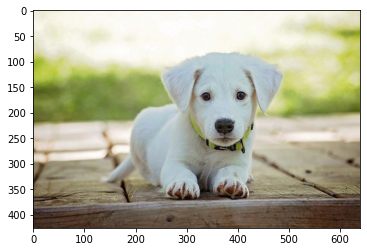

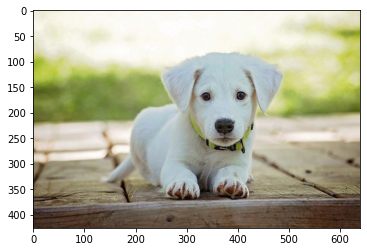

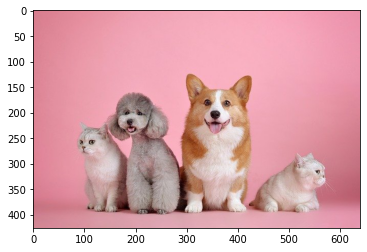

Query text: cat
Matches:
----------


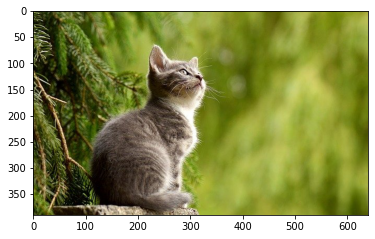

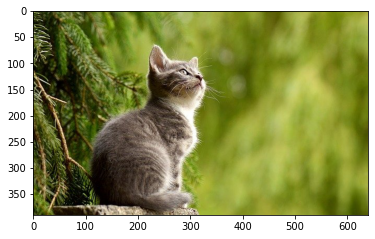

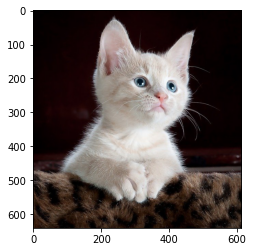

Query text: kids on their bikes
Matches:
----------


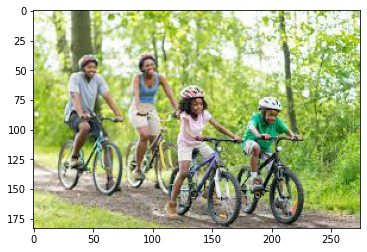

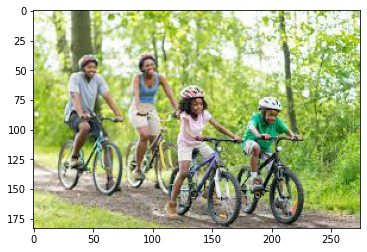

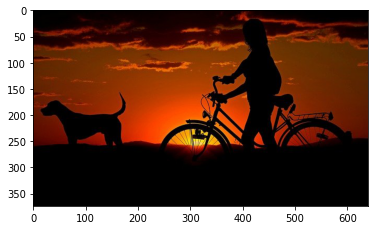

In [ ]:
with flow_search:
    resp = flow_search.post(on='/search',inputs=DocumentArray([
                    Document(text='dog'),
                    Document(text='cat'),
                    Document(text='kids on their bikes'),
                ]),on_done=plot_search_results)

In [ ]:
# clean up
! rm -rf workspace images query
! rm data.zip